In [1]:
import wrangle as w 
import os 
from env import get_db_url

import pandas as pd 
import numpy as np

from collections import Counter

from sklearn.model_selection import train_test_split

from datetime import date

import matplotlib.pyplot as plt
import seaborn as sns

# feature selection imports
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.feature_selection import RFE
from sklearn.model_selection import train_test_split

# import scaling methods
from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler, QuantileTransformer
from scipy import stats

# import modeling methods
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression, LassoLars, TweedieRegressor
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import explained_variance_score




In [2]:
# I've already prepared all this in the lesson. 
def acquire_zillow_data(use_cache=True):
    '''
    This function returns a snippet of zillow's database as a Pandas DataFrame. 
    When this SQL data is cached and extant in the os directory path, return the data as read into a df. 
    If csv is unavailable, aquisition proceeds regardless,
    reading the queried database elements into a dataframe, creating a cached csv file
    and lastly returning the dataframe for some sweet data science perusal.
    '''

    # If the cached parameter is True, read the csv file on disk in the same folder as this file 
    if os.path.exists('zillow.csv') and use_cache:
        print('Using cached CSV')
        return pd.read_csv('zillow.csv', dtype={'buildingclassdesc': 'str', 'propertyzoningdesc': 'str'})

    # When there's no cached csv, read the following query from Codeup's SQL database.
    print('CSV not detected.')
    print('Acquiring data from SQL database instead.')
    df = pd.read_sql(
        '''
 SELECT
    prop.*,
    predictions_2017.logerror,
    predictions_2017.transactiondate,
    air.airconditioningdesc,
    arch.architecturalstyledesc,
    build.buildingclassdesc,
    heat.heatingorsystemdesc,
    landuse.propertylandusedesc,
    story.storydesc,
    construct.typeconstructiondesc
FROM properties_2017 prop
JOIN (
    SELECT parcelid, MAX(transactiondate) AS max_transactiondate
    FROM predictions_2017
    GROUP BY parcelid
) pred USING(parcelid)
JOIN predictions_2017 ON pred.parcelid = predictions_2017.parcelid
                      AND pred.max_transactiondate = predictions_2017.transactiondate
LEFT JOIN airconditioningtype air USING (airconditioningtypeid)
LEFT JOIN architecturalstyletype arch USING (architecturalstyletypeid)
LEFT JOIN buildingclasstype build USING (buildingclasstypeid)
LEFT JOIN heatingorsystemtype heat USING (heatingorsystemtypeid)
LEFT JOIN propertylandusetype landuse USING (propertylandusetypeid)
LEFT JOIN storytype story USING (storytypeid)
LEFT JOIN typeconstructiontype construct USING (typeconstructiontypeid)
WHERE prop.latitude IS NOT NULL
  AND prop.longitude IS NOT NULL
  AND transactiondate <= '2017-12-31';             
        '''
                    , get_db_url('zillow'))
    
    df.propertyzoningdesc.astype(str)
    
    
    print('Acquisition Complete. Dataframe available and is now cached for future use.')
    # create a csv of the dataframe for the sake of efficiency. 
    df.to_csv('zillow.csv', index=False)
    
    return df

In [3]:
dirty_df = acquire_zillow_data()

Using cached CSV


In [4]:
def remove_columns(df, cols_to_remove):
    '''
    This function takes in a pandas dataframe and a list of columns to remove. It drops those columns from the original df and returns the df.
    '''
    df = df.drop(columns=cols_to_remove)
    return df
                 
                 
def handle_missing_values(df, prop_required_column=0.5 , prop_required_row=0.5):
    '''
    This function takes in a pandas dataframe, default proportion of required columns (set to 50%) and proprtion of required rows (set to 75%).
    It drops any rows or columns that contain null values more than the threshold specified from the original dataframe and returns that dataframe.
    
    Prior to returning that data, it will print statistics and list counts/names of removed columns/row counts 
    '''
    original_cols = df.columns.to_list()
    original_rows = df.shape[0]
    threshold = int(round(prop_required_column * len(df.index), 0))
    df = df.dropna(axis=1, thresh=threshold)
    threshold = int(round(prop_required_row * len(df.columns), 0))
    df = df.dropna(axis=0, thresh=threshold)
    remaining_cols = df.columns.to_list()
    remaining_rows = df.shape[0]
    dropped_col_count = len(original_cols) - len(remaining_cols)
    dropped_cols = list((Counter(original_cols) - Counter(remaining_cols)).elements())
    print(f'The following {dropped_col_count} columns were dropped because they were missing more than {prop_required_column * 100}% of data: \n{dropped_cols}\n')
    dropped_rows = original_rows - remaining_rows
    print(f'{dropped_rows} rows were dropped because they were missing more than {prop_required_row * 100}% of data')
    return df

# combined in one function
def data_prep(df, cols_to_remove=[], prop_required_column=0.5, prop_required_row=0.5):
    '''
    This function calls the remove_columns and handle_missing_values to drop columns that need to be removed. It also drops rows and columns that have more 
    missing values than the specified threshold.
    '''
    df = remove_columns(df, cols_to_remove)
    df = handle_missing_values(df, prop_required_column, prop_required_row)
    return df

def remove_outliers(df, k, col_list):
    ''' remove outliers from a list of columns in a dataframe 
        and return that dataframe
    '''
    
    for col in col_list:
        # get quartiles
        q1, q3 = df[f'{col}'].quantile([.25, .75])  
        # calculate interquartile range
        iqr = q3 - q1   
        # get upper bound
        upper_bound = q3 + k * iqr 
        # get lower bound
        lower_bound = q1 - k * iqr   

        # return dataframe without outliers
        
        df = df[(df[f'{col}'] > lower_bound) & (df[f'{col}'] < upper_bound)]
        
    return df

In [5]:
def prep_zillow(df):
    
    df = data_prep(df)
    
    df = df[(df.propertylandusedesc == 'Single Family Residential') |
      (df.propertylandusedesc == 'Mobile Home') |
      (df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
      (df.propertylandusedesc == 'Cluster Home')]
    
    # Remove properties that couldn't even plausibly be a studio. 
    df= df[(df.bedroomcnt > 0) & (df.bathroomcnt > 0)]
    
    # Remove properties where there is not a single bathroom.
    df = df[df.bathroomcnt > 0]
    
 # keep only properties with square footage greater than 70 (legal size of a bedroom)
    df = df[df.calculatedfinishedsquarefeet > 70]
    
    # Minimum lot size of single family units.
    df = df[df.lotsizesquarefeet >= 5000].copy()
    
    
    
    #df = df[~df['propertylandusetypeid'].isin([263, 265, 275])]
    
    # Clear indicators of single unit family. Other codes non-existent or indicate commercial sites. 
   # 0100 - Single Residence
   # 0101 Single residence with pool
   # 0104 - Single resident with therapy pool 
    df = df[(df.propertycountylandusecode == '0100') |
            (df.propertycountylandusecode == '0101') |
            (df.propertycountylandusecode == '0104') |
            (df.propertycountylandusecode == '122') | 
            (df.propertycountylandusecode == '1111') |
            (df.propertycountylandusecode == '1110') |
            (df.propertycountylandusecode == '1')
           ]
    
    
    # Remove 13 rows where unit count is 2. The NaN's can be safely assumed as 1 and were just mislabeled in other counties.  
    df = df[df['unitcnt'] != 2]
    df['unitcnt'].fillna(1)
    
    
    # Property where finished area is 152 but bed count is 5. 
    df = df.drop(labels=75325, axis=0)
    
      
            
    # Redudant columns or uninterpretable columns
    # Unit count was dropped because now its known that theyre all 1. 
    # Finished square feet is equal to calculated sq feet. 
    # full bathcnt and calculatedbathnbr are equal to bathroomcnt
    # property zoning desc is unreadable. 
    # assessment year is unnecessary, all values are 2016. 
    # property land use desc is always single family residence 
    # same with property landuse type id. 
    # room count must be for a different category, as it is always 0.
    # regionidcounty reveals the same information as FIPS. 
    # heatingorsystemtypeid is redundant. Encoded descr. 
    # Id does nothing, and parcelid is easier to represent. 

    
    df =df.drop(columns= ['finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
                      'propertyzoningdesc', 'unitcnt', 'propertylandusedesc',
                      'assessmentyear', 'roomcnt', 'regionidcounty', 'propertylandusetypeid',
                      'heatingorsystemtypeid', 'id', 'heatingorsystemdesc', 'buildingqualitytypeid'],
            axis=1)
    
    
    # The last nulls can be dropped altogether. 
    df = df.dropna()
 

    df['yearbuilt'] = df['yearbuilt'].astype(int)
    df.yearbuilt = df.yearbuilt.astype(object) 
    df['age'] = 2017-df['yearbuilt']
    df = df.drop(columns='yearbuilt')
    df['age'] = df['age'].astype('int')
    print('Yearbuilt converted to age. \n')
    
    # Removing problematic outlier groups.  
    df = remove_outliers(df, 3, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                                'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet'])
    
    df = df.set_index('parcelid')
    
    return df



In [6]:
def nulls_by_col(df):
    '''
    This function  takes in a dataframe of observations and attributes(or columns) and returns a dataframe where each row is an atttribute name, the first column is the 
    number of rows with missing values for that attribute, and the second column is percent of total rows that have missing values for that attribute.
    '''
    num_missing = df.isnull().sum()
    rows = df.shape[0]
    prcnt_miss = (num_missing / rows * 100)
    cols_missing = pd.DataFrame({'num_rows_missing': num_missing, 
                                 'percent_rows_missing': prcnt_miss})\
    .sort_values(by='percent_rows_missing', ascending=False)
    return cols_missing.applymap(lambda x: f"{x:0.1f}")

def nulls_by_row(df):
    '''
    This function takes in a dataframe and returns a dataframe with 3 columns: the number of columns missing, percent of columns missing, 
    and number of rows with n columns missing.
    '''
    num_missing = df.isnull().sum(axis = 1)
    prcnt_miss = (num_missing / df.shape[1] * 100)
    rows_missing = pd.DataFrame({'num_cols_missing': num_missing, 
                                 'percent_cols_missing': prcnt_miss})\
    .reset_index()\
    .groupby(['num_cols_missing', 'percent_cols_missing']).count()\
    .rename(index=str, columns={'index': 'num_rows'}).reset_index().set_index('num_cols_missing')\
    .sort_values(by='percent_cols_missing', ascending=False)
    return rows_missing

def describe_data(df):
    '''
    This function takes in a pandas dataframe and prints out the shape, datatypes, number of missing values, 
    columns and their data types, summary statistics of numeric columns in the dataframe, as well as the value counts for categorical variables.
    '''
    # Print out the "shape" of our dataframe - rows and columns
    print(f'This dataframe has {df.shape[0]} rows and {df.shape[1]} columns.')
    print('')
    print('--------------------------------------')
    print('--------------------------------------')
    
    # print the datatypes and column names with non-null counts
    print(df.info())
    print('')
    print('--------------------------------------')
    print('--------------------------------------')
    
    
    # print out summary stats for our dataset
    print('Here are the summary statistics of our dataset')
    print(df.describe().applymap(lambda x: f"{x:0.3f}"))
    print('')
    print('--------------------------------------')
    print('--------------------------------------')

    # print the number of missing values per column and the total
    print('Null Values by Column: ')
    missing_total = df.isnull().sum().sum()
    missing_count = df.isnull().sum() # the count of missing values
    value_count = df.isnull().count() # the count of all values
    missing_percentage = round(missing_count / value_count * 100, 2) # percentage of missing values
    missing_df = pd.DataFrame({'count': missing_count, 'percentage': missing_percentage})\
    .sort_values(by='percentage', ascending=False)
    
    print(missing_df.head(50))
    print(f' \n Total Number of Missing Values: {missing_total} \n')
    df_total = df.shape[0] * df.shape[1]
    proportion_of_nulls = round((missing_total / df_total), 4)
    print(f' Proportion of Nulls in Dataframe: {proportion_of_nulls}\n') 
    print('--------------------------------------')
    print('--------------------------------------')
    
    print('Row-by-Row Nulls')
    print(nulls_by_row(df))
    print('----------------------')
    
    print('Relative Frequencies: \n')
    ## Display top 5 values of each variable within reasonable limit
    limit = 25
    for col in df.columns:
        if df[col].nunique() < limit:
            print(f'Column: {col} \n {round(df[col].value_counts(normalize=True).nlargest(5), 3)} \n')
        else: 
            print(f'Column: {col} \n')
            print(f'Range of Values: [{df[col].min()} - {df[col].max()}] \n')
        print('------------------------------------------')
        print('--------------------------------------')

Justifications for these removals listed below. Copied from previous notebooks located in the clustering-exercises repository

In [7]:
describe_data(dirty_df)

This dataframe has 77380 rows and 68 columns.

--------------------------------------
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77380 entries, 0 to 77379
Data columns (total 68 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   id                            77380 non-null  int64  
 1   parcelid                      77380 non-null  int64  
 2   airconditioningtypeid         24953 non-null  float64
 3   architecturalstyletypeid      206 non-null    float64
 4   basementsqft                  50 non-null     float64
 5   bathroomcnt                   77380 non-null  float64
 6   bedroomcnt                    77380 non-null  float64
 7   buildingclasstypeid           15 non-null     float64
 8   buildingqualitytypeid         49671 non-null  float64
 9   calculatedbathnbr             76771 non-null  float64
 10  decktypeid                    614 non-null    float64

TypeError: '<=' not supported between instances of 'float' and 'str'

# .49 of data frame has missing values. 
So there's a lot to tackle. 
I first set to distinguish which properties would most likely be single unit family residences. Among these

           array(['Single Family Residential', 'Condominium',
                  'Duplex (2 Units, Any Combination)', 'Residential General',
                  'Planned Unit Development', 'Triplex (3 Units, Any Combination)',
                  'Quadruplex (4 Units, Any Combination)', 'Cluster Home',
                  'Commercial/Office/Residential Mixed Used', 'Cooperative',
                  'Manufactured, Modular, Prefabricated Homes', 'Mobile Home',
                  'Townhouse']
                  
Single Family Residential, Mobile Home, Manufactured Modular, and Cluster Home all seemed acceptable, so I sliced the dataframe up, keeping only those four. 

Then I removed properties that couldn't be even a studio; hence onces where there are 0 baths and 0 beds. 0 beds alone wouldn't be too unusual, although very cramped, but not having a bath is unacceptable. So then I removed all properties where bathroom count was at 0. 

The legal size of a bedroom is 70 sq feet, so I removed properties that were less than 70 for their area. California has a minimum lot size of 5000 sqfeet per single family unit. Consequently, those beneath that threshold were removed. 

In [18]:
# a quick walkthrough of losses up to this point. 
less_dirty_df = data_prep(dirty_df)

The following 34 columns were dropped because they were missing more than 50.0% of data: 
['airconditioningtypeid', 'architecturalstyletypeid', 'basementsqft', 'buildingclasstypeid', 'decktypeid', 'finishedfloor1squarefeet', 'finishedsquarefeet13', 'finishedsquarefeet15', 'finishedsquarefeet50', 'finishedsquarefeet6', 'fireplacecnt', 'garagecarcnt', 'garagetotalsqft', 'hashottuborspa', 'poolcnt', 'poolsizesum', 'pooltypeid10', 'pooltypeid2', 'pooltypeid7', 'regionidneighborhood', 'storytypeid', 'threequarterbathnbr', 'typeconstructiontypeid', 'yardbuildingsqft17', 'yardbuildingsqft26', 'numberofstories', 'fireplaceflag', 'taxdelinquencyflag', 'taxdelinquencyyear', 'airconditioningdesc', 'architecturalstyledesc', 'buildingclassdesc', 'storydesc', 'typeconstructiondesc']

0 rows were dropped because they were missing more than 50.0% of data


In [19]:
print(less_dirty_df.shape)
# this dropped columns based on a threshold. 
# if the column is missing more than 50% of its values, it goes away
# the same would apply to rows, but no rows were dropped on these grounds

less_dirty_df = less_dirty_df[(less_dirty_df.propertylandusedesc == 'Single Family Residential') |
  (less_dirty_df.propertylandusedesc == 'Mobile Home') |
  (less_dirty_df.propertylandusedesc == 'Manufactured, Modular, Prefabricated Homes') |
  (less_dirty_df.propertylandusedesc == 'Cluster Home')]
less_dirty_df.shape

rows_lost = (77380-52784)/ 77380 
print(f' So far {round(rows_lost,2)} percent of rows have been lost')

(77380, 34)
 So far 0.32 percent of rows have been lost


In [20]:
 # Remove properties that couldn't even plausibly be a studio. 
less_dirty_df= less_dirty_df[(less_dirty_df.bedroomcnt > 0) & (less_dirty_df.bathroomcnt > 0)]
    
    # Remove properties where there is not a single bathroom.
less_dirty_df = less_dirty_df[less_dirty_df.bathroomcnt > 0]
    
 # keep only properties with square footage greater than 70 (legal size of a bedroom)
less_dirty_df = less_dirty_df[less_dirty_df.calculatedfinishedsquarefeet > 70]
    
    # Minimum lot size of single family units.
less_dirty_df = less_dirty_df[less_dirty_df.lotsizesquarefeet >= 5000].copy()

In [21]:
less_dirty_df.shape
# another 8 thousands rows lost. But the content is looking cleaner. 

(44130, 34)

In [22]:
# Clear indicators of single unit family. Other codes non-existent or indicate commercial sites. 
# 0100 - Single Residence
# 0101 Single residence with pool
# 0104 - Single resident with therapy pool
# the others are for orange and Ventura, each representing similar data
less_dirty_df = less_dirty_df[(less_dirty_df.propertycountylandusecode == '0100') |
        (less_dirty_df.propertycountylandusecode == '0101') |
        (less_dirty_df.propertycountylandusecode == '0104') |
        (less_dirty_df.propertycountylandusecode == '122') | 
        (less_dirty_df.propertycountylandusecode == '1111') |
        (less_dirty_df.propertycountylandusecode == '1110') |
        (less_dirty_df.propertycountylandusecode == '1')
                             ]

In [23]:
less_dirty_df.shape
# only four thousand rows lost. 

(43806, 34)

In [24]:
# Remove rows where unit count is 2. The NaN's can be safely assumed as 1 and were just mislabeled in other counties.  
less_dirty_df = less_dirty_df[less_dirty_df['unitcnt'] != 2]
less_dirty_df['unitcnt'].fillna(1)
less_dirty_df.shape

(43793, 34)

In [25]:
# Property where finished area is 152 but bed count is 5. 
less_dirty_df = less_dirty_df.drop(labels=75325, axis=0)

In [26]:
# each of these columns were redundant (equal to others) or had too many nulls and couldn't be imputed
less_dirty_df =less_dirty_df.drop(columns= ['finishedsquarefeet12', 'fullbathcnt', 'calculatedbathnbr',
                  'propertyzoningdesc', 'unitcnt', 'propertylandusedesc',
                  'assessmentyear', 'roomcnt', 'regionidcounty', 'propertylandusetypeid',
                  'heatingorsystemtypeid', 'id', 'heatingorsystemdesc', 'buildingqualitytypeid'],
        axis=1)

In [27]:
less_dirty_df.shape
# only one row was lost, and 14 unnecessary columns were removed. 

(43792, 20)

In [28]:
describe_data(less_dirty_df)

This dataframe has 43792 rows and 20 columns.

--------------------------------------
--------------------------------------
<class 'pandas.core.frame.DataFrame'>
Int64Index: 43792 entries, 1 to 77379
Data columns (total 20 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      43792 non-null  int64  
 1   bathroomcnt                   43792 non-null  float64
 2   bedroomcnt                    43792 non-null  float64
 3   calculatedfinishedsquarefeet  43792 non-null  float64
 4   fips                          43792 non-null  float64
 5   latitude                      43792 non-null  float64
 6   longitude                     43792 non-null  float64
 7   lotsizesquarefeet             43792 non-null  float64
 8   propertycountylandusecode     43792 non-null  object 
 9   rawcensustractandblock        43792 non-null  float64
 10  regionidcity                  42921 non-null  float64

In [29]:
# due to the small number of nulls at less than 0%, I dropped the remaining.
less_dirty_df = less_dirty_df.dropna()

In [30]:
# created an age column, droppped yearbuilt

less_dirty_df['yearbuilt'] = less_dirty_df['yearbuilt'].astype(int)
less_dirty_df.yearbuilt = less_dirty_df.yearbuilt.astype(object) 
less_dirty_df['age'] = 2017-less_dirty_df['yearbuilt']
less_dirty_df = less_dirty_df.drop(columns='yearbuilt')
less_dirty_df['age'] = less_dirty_df['age'].astype('int')
print('Yearbuilt converted to age. \n')

Yearbuilt converted to age. 



In [31]:
less_dirty_df.shape

(42824, 20)

In [32]:
# Removing problematic outlier groups.  
less_dirty_df = remove_outliers(less_dirty_df, 3, ['lotsizesquarefeet', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt',
                            'landtaxvaluedollarcnt', 'taxamount', 'calculatedfinishedsquarefeet'])

In [33]:
less_dirty_df.shape

(37974, 20)

In [34]:
less_dirty_df = less_dirty_df.set_index('parcelid')

In [35]:
df = less_dirty_df.copy()

In [36]:
df.regionidcity = df.regionidcity.astype(int)

In [37]:
df.regionidcity.astype(str).apply(len).value_counts()

5    34025
4     2524
6     1425
Name: regionidcity, dtype: int64

In [38]:
df = df[df.regionidcity.astype(str).apply(len) == 5]

In [39]:
df.regionidzip = df.regionidzip.astype(int)

In [40]:
df = df[df.regionidzip.astype(str).apply(len) == 5]

In [41]:
df = df[df.regionidzip.astype(str).apply(len) == 5]

In [42]:
df.shape

(34022, 19)

In [43]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,regionidzip,structuretaxvaluedollarcnt,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,age
parcelid,,,,,,,,,,,,,,,,,,,
17052889,1.0,2.0,1465.0,6111.0,34449266.0,-119281531.0,12647.0,1110,6.111001e+07,13091,97099,88000.0,464000.0,376000.0,5672.48,6.111001e+13,0.055619,2017-01-01,50
14186244,2.0,3.0,1243.0,6059.0,33886168.0,-117823170.0,8432.0,122,6.059022e+07,21412,97078,85289.0,564778.0,479489.0,6488.30,6.059022e+13,0.005383,2017-01-01,55
11104527,3.0,4.0,2540.0,6037.0,34434971.0,-118464390.0,10384.0,0101,6.037920e+07,54311,96374,271715.0,430108.0,158393.0,6103.36,6.037920e+13,0.005963,2017-01-02,18
14375300,2.0,4.0,1677.0,6059.0,33642800.0,-117707211.0,5304.0,122,6.059052e+07,32380,96962,169118.0,528847.0,359729.0,5496.44,6.059052e+13,-0.021896,2017-01-02,36
14387959,2.5,3.0,2074.0,6059.0,33586693.0,-117697202.0,5600.0,122,6.059042e+07,25458,96971,173269.0,597213.0,423944.0,6172.28,6.059042e+13,-0.006653,2017-01-02,39
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12892446,3.0,4.0,2068.0,6037.0,34075094.0,-117773759.0,7333.0,0100,6.037402e+07,20008,96508,211040.0,332251.0,121211.0,4225.84,6.037402e+13,0.319408,2017-09-19,50
10722691,2.0,3.0,1570.0,6037.0,34194943.0,-118629218.0,7499.0,0100,6.037135e+07,12447,96342,46784.0,72026.0,25242.0,1000.70,6.037135e+13,0.081196,2017-09-19,59
17239384,2.0,4.0,1612.0,6111.0,34300140.0,-118706327.0,12105.0,1111,6.111008e+07,27110,97116,50683.0,67205.0,16522.0,1107.48,6.111008e+13,0.013209,2017-09-21,53


In [46]:
df = remove_outliers(df, 3, ['bathroomcnt', 'bedroomcnt'])

In [47]:
df.shape

(33956, 19)

In [48]:
df = df.drop(labels=12414696, axis=0)

['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age']
['propertycountylandusecode', 'transactiondate']


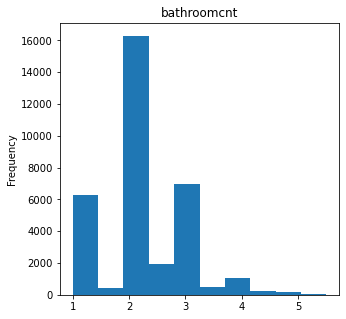

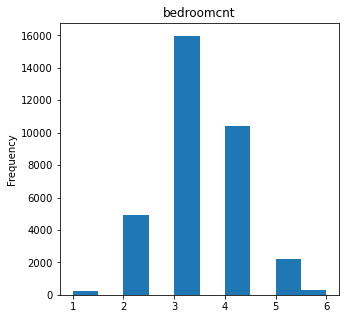

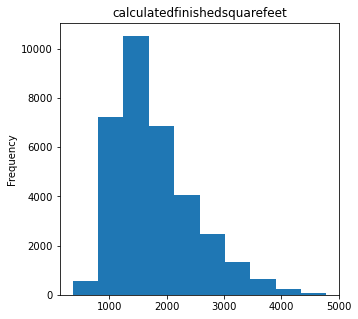

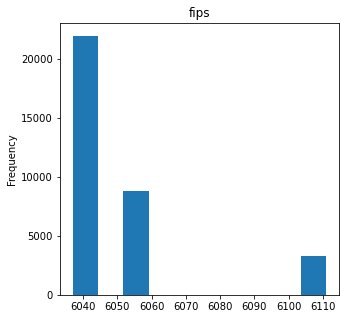

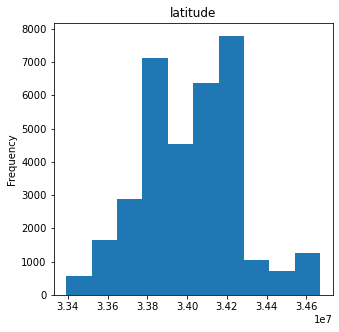

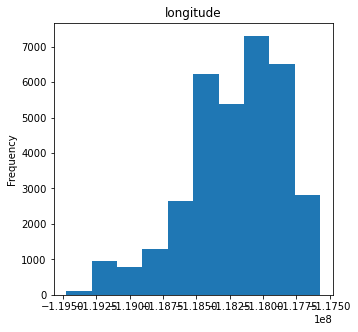

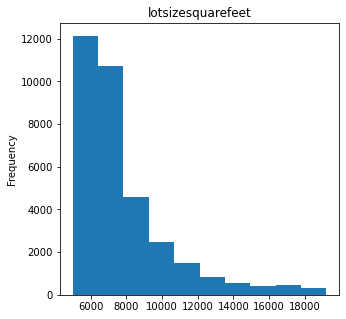

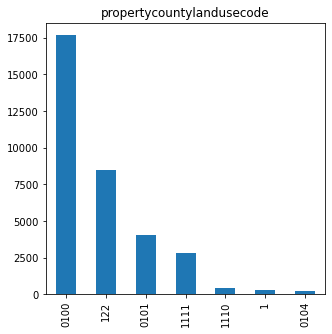

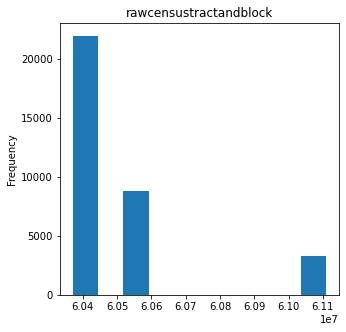

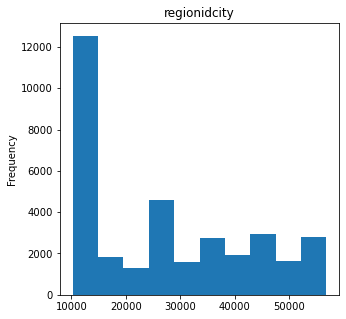

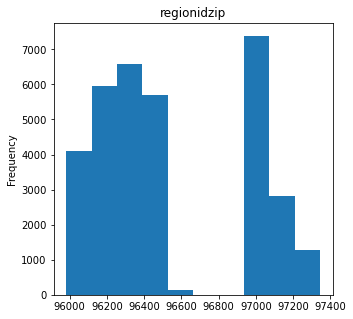

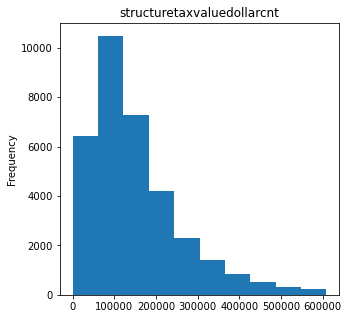

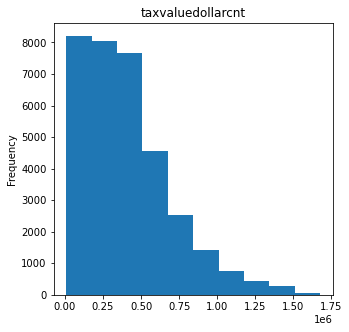

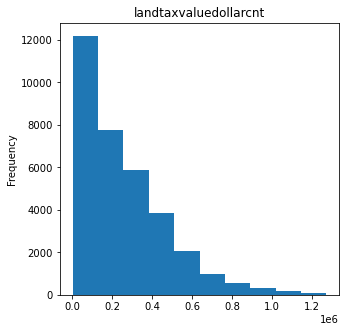

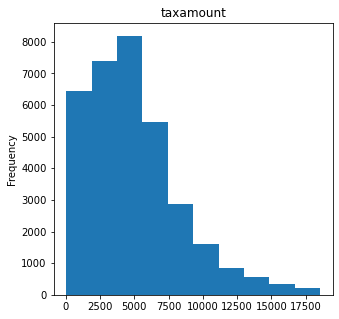

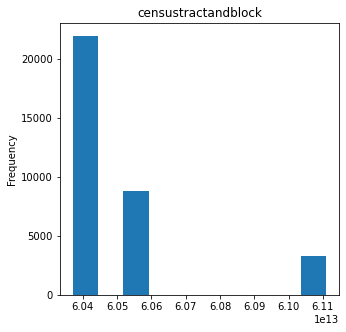

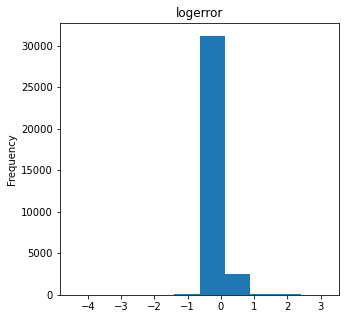

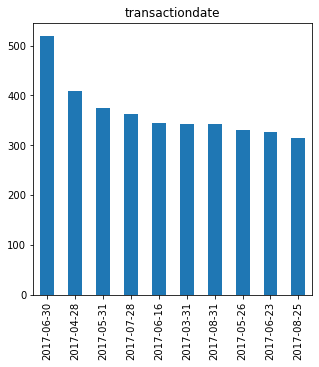

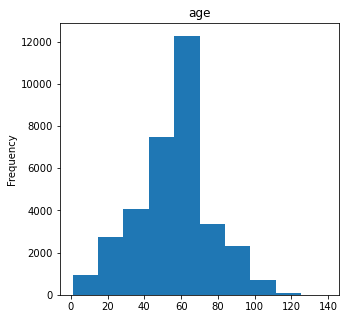

In [50]:
num_list = []
cat_list = []

for column in df:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df[column]) :
        # show only the TOP 10 value count in each categorical data
        df[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

Raw census tract and block provides the same information as FIPS and can be discarded, especially since there is a non-raw version. 
The standard census tract and block has some error that needs to be investigated. 


In [ ]:
# there's the offender. THe only one with a 4. instead of a six, and +14 instead of +13. It needs to go. 
# Investigated and fixed using df = df.drop(labels=12414696, axis=0)

In [51]:
df['checking_tax'] = df['structuretaxvaluedollarcnt'] + df['landtaxvaluedollarcnt']
looksee = df['checking_tax'] == df['taxvaluedollarcnt']
looksee.value_counts()

True    33955
dtype: int64

In [52]:
df.shape

(33955, 20)

In [55]:
 # create taxrate variable
df['taxrate'] = round(df.taxamount/df.taxvaluedollarcnt*100, 2)

In [57]:
# create acres variable
df['acres'] = df.lotsizesquarefeet/43560

In [58]:
df

,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,latitude,longitude,lotsizesquarefeet,propertycountylandusecode,rawcensustractandblock,regionidcity,...,taxvaluedollarcnt,landtaxvaluedollarcnt,taxamount,censustractandblock,logerror,transactiondate,age,checking_tax,taxrate,acres
parcelid,,,,,,,,,,,,,,,,,,,,,
14047504,5.5,4.0,3938.0,6059.0,33655948.0,-117965345.0,6720.0,122,6.059099e+07,25218,...,1354343.0,886869.0,15007.10,6.059099e+13,0.048133,2017-01-23,27,1354343.0,1.11,0.154270
17196409,5.5,5.0,4764.0,6111.0,34304384.0,-118889991.0,16287.0,1111,6.111008e+07,25974,...,1257000.0,817000.0,14041.98,6.111008e+13,0.036965,2017-06-23,13,1257000.0,1.12,0.373898
14395908,5.5,5.0,3812.0,6059.0,33560779.0,-117696084.0,7670.0,122,6.059042e+07,25459,...,1429000.0,973089.0,14408.36,6.059042e+13,0.035690,2017-06-06,14,1429000.0,1.01,0.176079
17205098,5.5,4.0,4708.0,6111.0,34299279.0,-118878415.0,12385.0,1111,6.111008e+07,25974,...,998000.0,647000.0,10958.94,6.111008e+13,0.003927,2017-03-31,10,998000.0,1.10,0.284320
17188460,5.5,5.0,4094.0,6111.0,34207532.0,-119025357.0,7595.0,1111,6.111006e+07,51239,...,895000.0,581000.0,9599.78,6.111006e+13,-0.042841,2017-09-05,10,895000.0,1.07,0.174357
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12067634,1.0,2.0,1422.0,6037.0,34159796.0,-118246865.0,6166.0,0100,6.037301e+07,45457,...,636366.0,509094.0,6925.50,6.037301e+13,-0.138843,2017-04-21,87,636366.0,1.09,0.141552
12071148,1.0,2.0,1452.0,6037.0,34162536.0,-118248116.0,6872.0,0100,6.037301e+07,45457,...,411132.0,328911.0,4566.37,6.037301e+13,0.007501,2017-04-26,81,411132.0,1.11,0.157759
12071365,1.0,3.0,1948.0,6037.0,34161711.0,-118244347.0,6711.0,0100,6.037301e+07,45457,...,102039.0,42637.0,1244.01,6.037301e+13,-0.239963,2017-01-23,90,102039.0,1.22,0.154063


In [113]:
# dollar per square foot- structure
less_dirty_df['structure_cost_per_sqft_again'] = df.structuretaxvaluedollarcnt/df.lotsizesquarefeet

In [63]:
# dollar per square foot- land
df['land_cost_per_sqft'] = df.landtaxvaluedollarcnt/df.lotsizesquarefeet

An important thing to remember here is that the building value is depreciable, the land value is not.

Generally speaking an 80% building to a 20% land value is a rule of thumb. So $720,000.00 for the building and $180,000.00 for the land value. This would be a normal situation.

In [110]:
mitosheet.sheet(less_dirty_df, analysis_to_replay="id-jphyommxme")

MitoWidget(analysis_data_json='{"analysisName": "id-upnqiuxsij", "analysisToReplay": {"analysisName": "id-jphy…

In [ ]:
from mitosheet import *; register_analysis("id-jphyommxme");
    
# Deleted column land_dollar_per_sqft from less_dirty_df
less_dirty_df.drop(['land_dollar_per_sqft'], axis=1, inplace=True)

# Sorted land_cost_per_sqft in less_dirty_df in ascending order
less_dirty_df = less_dirty_df.sort_values(by='land_cost_per_sqft', ascending=True, na_position='first')


/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_8874/2263778959.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'checking_tax', 'taxrate', 'acres', 'structure_cost_per_sqft', 'land_dollar_per_sqft', 'land_cost_per_sqft', 'bath_bed_ratio']
['propertycountylandusecode', 'transactiondate']


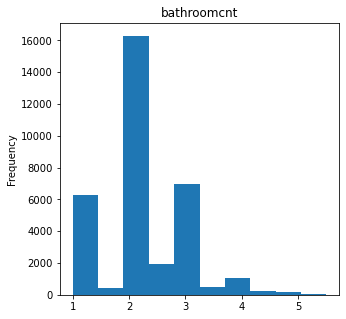

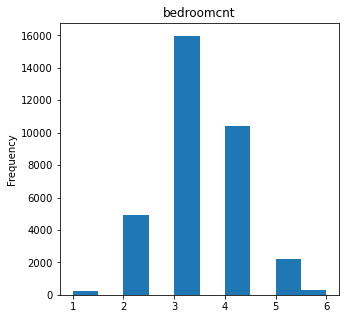

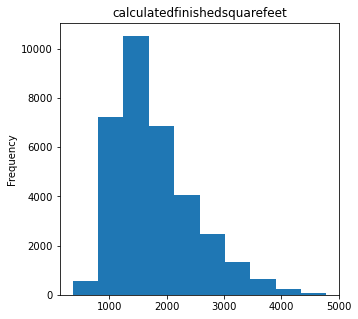

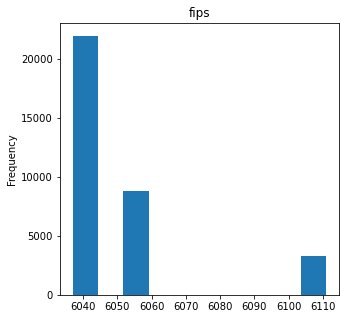

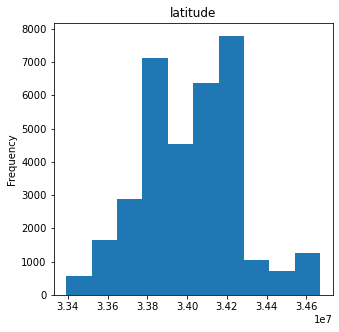

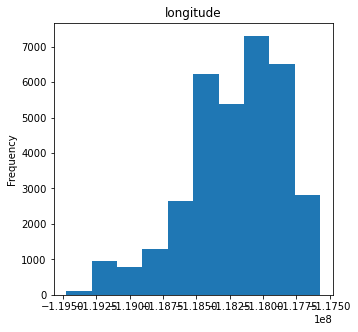

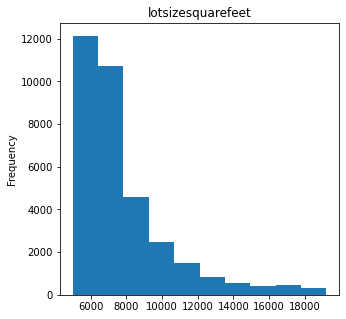

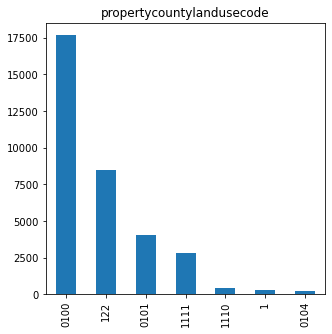

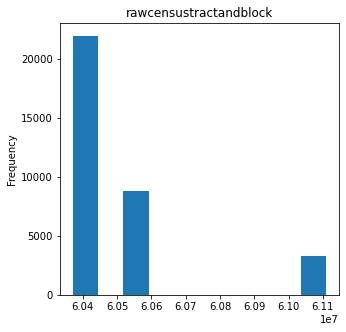

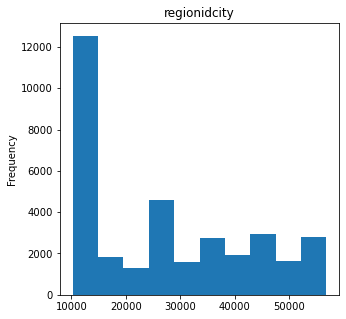

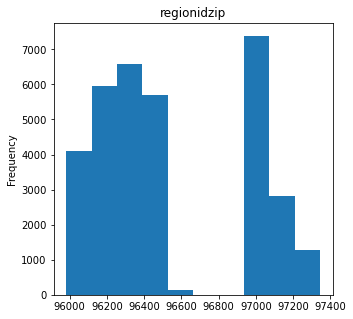

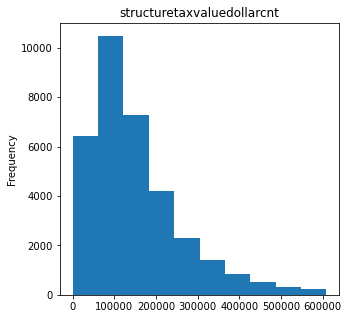

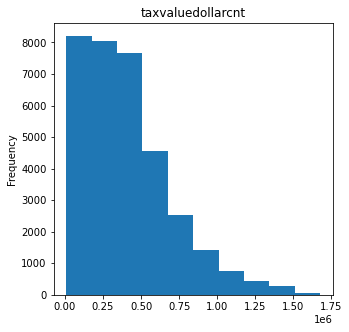

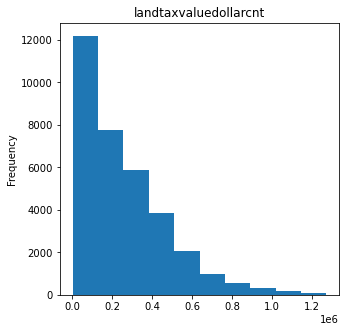

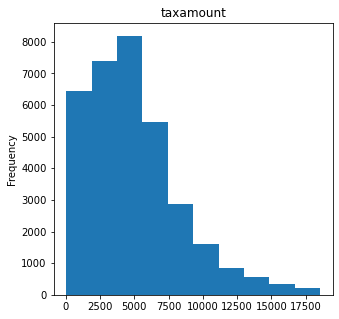

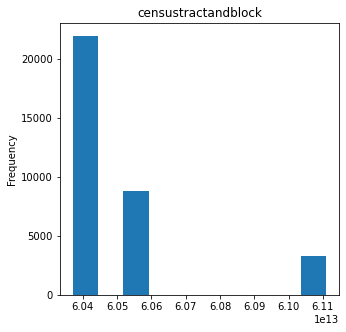

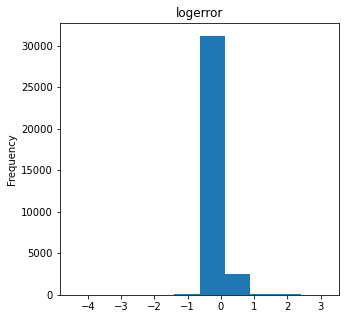

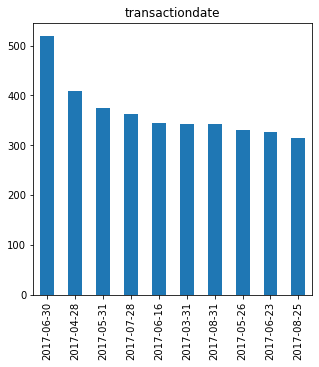

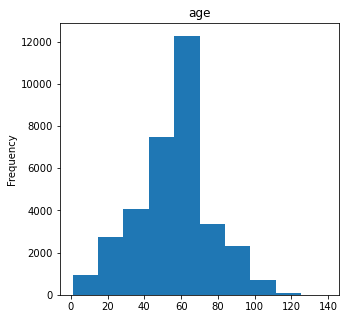

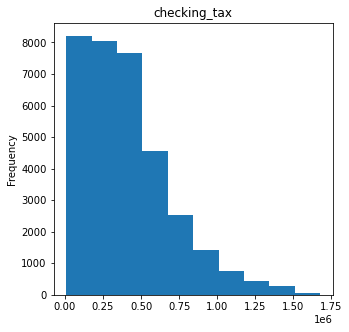

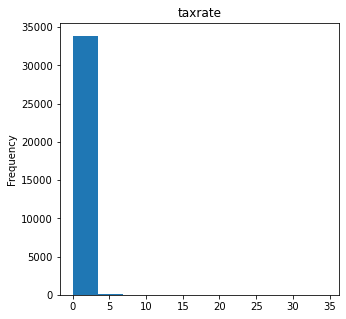

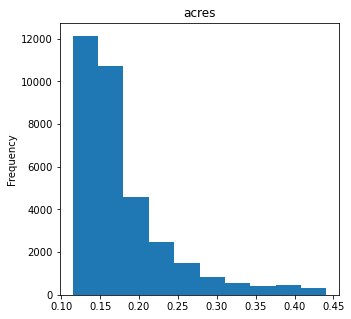

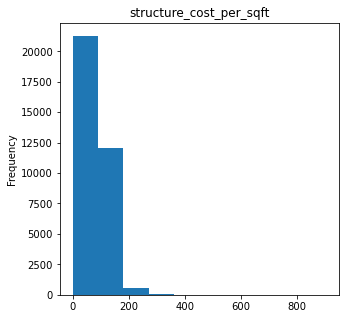

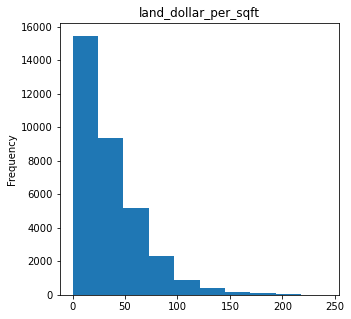

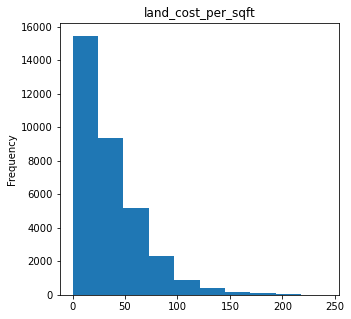

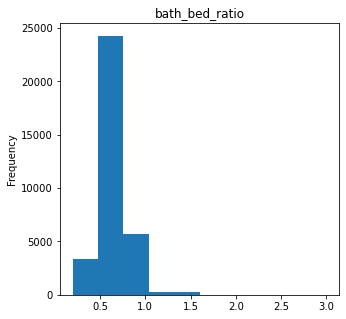

In [87]:
num_list = []
cat_list = []

for column in df:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(df[column]):
        df[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(df[column]) :
        # show only the TOP 10 value count in each categorical data
        df[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

after making this, I can clearly see that tax rate, structure cost per square foot, and bath_bed_ratio are plagued by some terrible outlier or erroneous input. 

In [ ]:
from mitosheet import *; register_analysis("id-pejnauorar");
    
# Sorted bath_bed_ratio in df in descending order
df = df.sort_values(by='bath_bed_ratio', ascending=False, na_position='last')

# Sorted calculatedfinishedsquarefeet in df in descending order
df = df.sort_values(by='calculatedfinishedsquarefeet', ascending=False, na_position='last')

# Sorted land_cost_per_sqft in df in descending order
df = df.sort_values(by='land_cost_per_sqft', ascending=False, na_position='last')


In [108]:
less_dirty_df = remove_outliers(less_dirty_df, 1.5, ['taxrate', 'structure_cost_per_sqft', 'bath_bed_ratio', 'land_cost_per_sqft', 'age'])

/var/folders/qn/sd1_3x2j4196db03067vql600000gn/T/ipykernel_8874/2973444663.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(column, figsize = (5,5))


['bathroomcnt', 'bedroomcnt', 'calculatedfinishedsquarefeet', 'fips', 'latitude', 'longitude', 'lotsizesquarefeet', 'rawcensustractandblock', 'regionidcity', 'regionidzip', 'structuretaxvaluedollarcnt', 'taxvaluedollarcnt', 'landtaxvaluedollarcnt', 'taxamount', 'censustractandblock', 'logerror', 'age', 'checking_tax', 'taxrate', 'acres', 'structure_cost_per_sqft', 'land_dollar_per_sqft', 'land_cost_per_sqft', 'bath_bed_ratio']
['propertycountylandusecode', 'transactiondate']


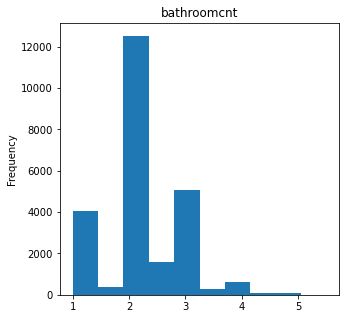

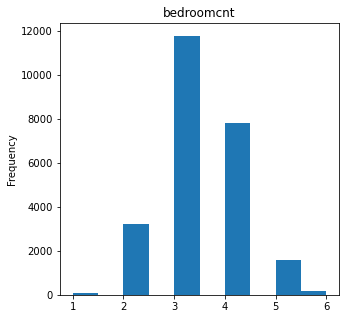

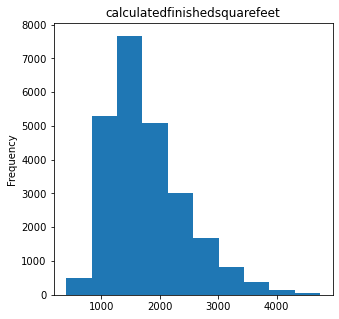

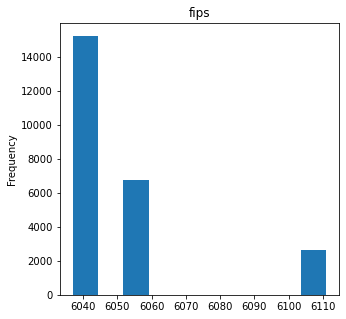

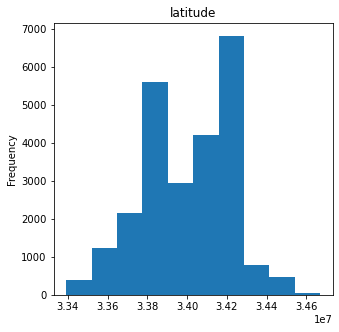

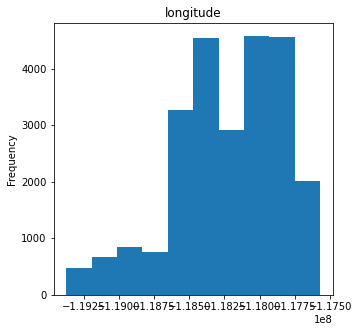

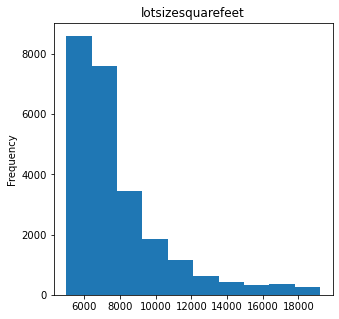

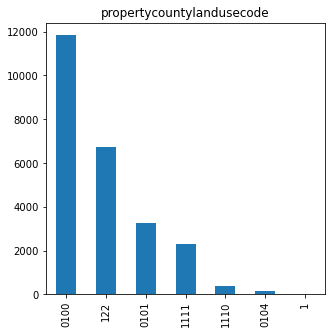

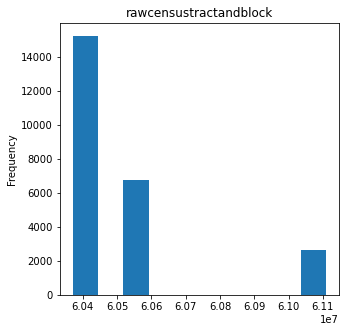

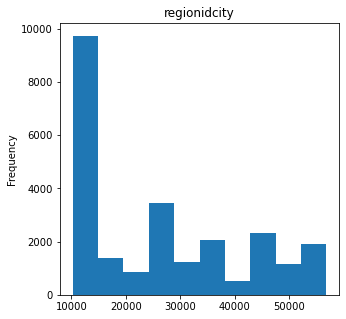

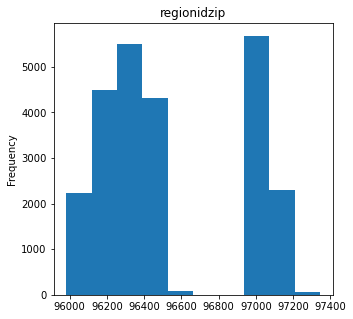

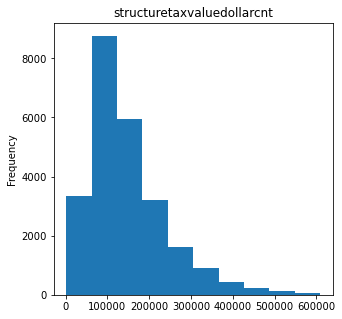

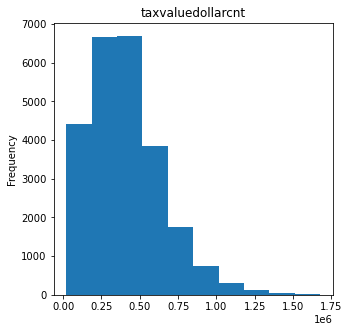

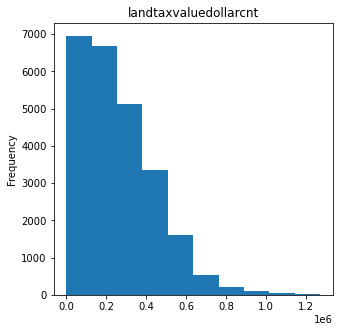

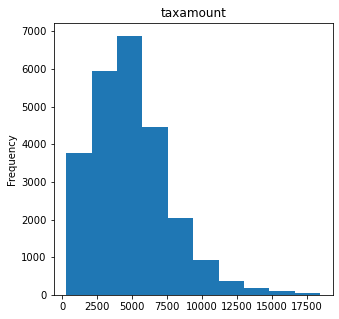

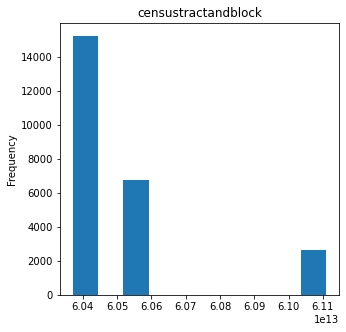

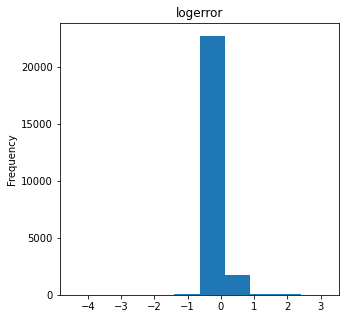

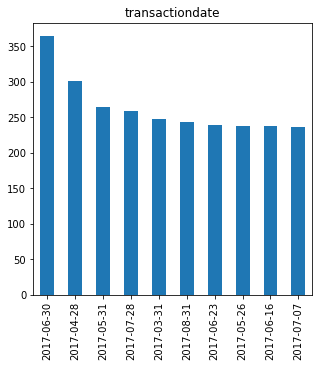

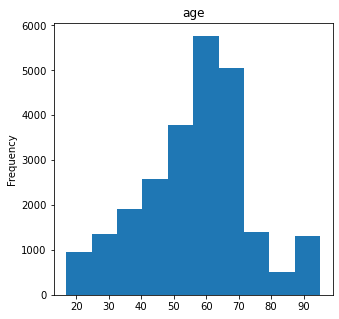

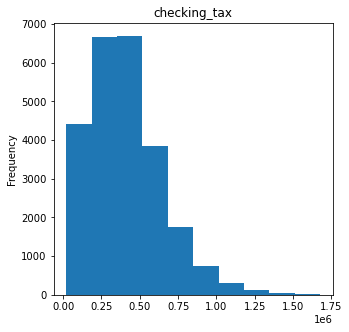

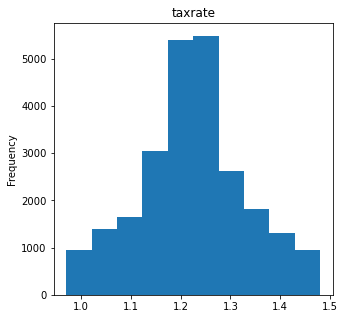

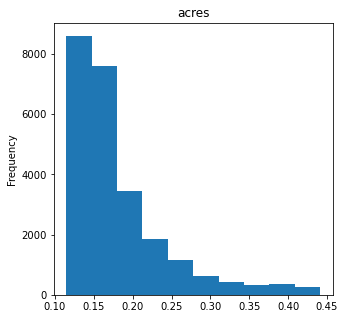

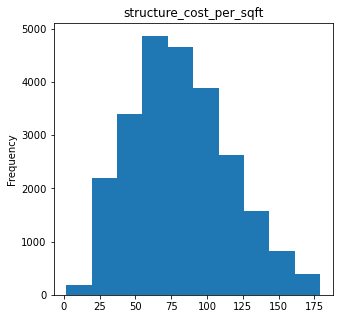

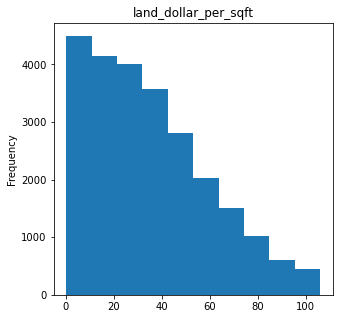

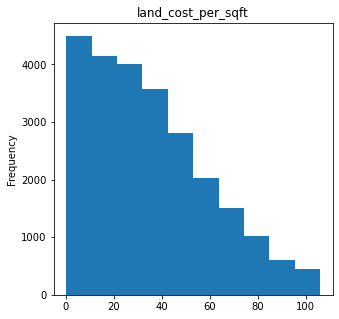

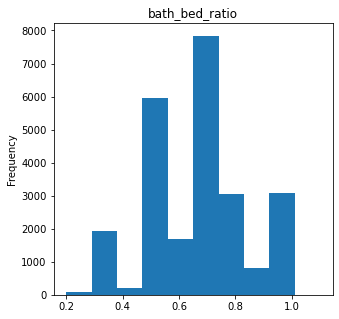

In [109]:
num_list = []
cat_list = []

for column in less_dirty_df:
    plt.figure(column, figsize = (5,5))
    plt.title(column)
    if pd.api.types.is_numeric_dtype(less_dirty_df[column]):
        less_dirty_df[column].plot(kind = 'hist')
        num_list.append(column)
    elif pd.api.types.is_string_dtype(less_dirty_df[column]) :
        # show only the TOP 10 value count in each categorical data
        less_dirty_df[column].value_counts()[:10].plot(kind = 'bar')
        cat_list.append(column)
        
print(num_list)
print(cat_list)

https://www.livabl.com/2021/07/la-third-hottest-market-increasing-land-values.html

Astonishingly enough, this information about land value per square foot is honestly appropriate. 
The median price per square foot for land now amounts to $1.38, which is lower than many other metros on the list due to Los Angeles’ immense size. Faced with a severe housing shortage and geography challenges, LA land values aren’t expected to fall anytime soon.

In [114]:
mitosheet.sheet(less_dirty_df, analysis_to_replay="id-kitounqtnx")

MitoWidget(analysis_data_json='{"analysisName": "id-kitounqtnx", "analysisToReplay": null, "code": [], "stepSu…

In [ ]:
from mitosheet import *; register_analysis("id-kitounqtnx");
    
# Sorted calculatedfinishedsquarefeet in less_dirty_df in ascending order
less_dirty_df = less_dirty_df.sort_values(by='calculatedfinishedsquarefeet', ascending=True, na_position='first')

# Sorted logerror in less_dirty_df in descending order
less_dirty_df = less_dirty_df.sort_values(by='logerror', ascending=False, na_position='last')

# Sorted logerror in less_dirty_df in ascending order
less_dirty_df = less_dirty_df.sort_values(by='logerror', ascending=True, na_position='first')

# Sorted taxrate in less_dirty_df in ascending order
less_dirty_df = less_dirty_df.sort_values(by='taxrate', ascending=True, na_position='first')


In [ ]:
from mitosheet import *; register_analysis("id-alhsiscndy");
    
# Filtered bedroomcnt in less_dirty_df
less_dirty_df = less_dirty_df[~less_dirty_df['bedroomcnt'].isin([6, 1])]

# Sorted taxrate in less_dirty_df in descending order
less_dirty_df = less_dirty_df.sort_values(by='taxrate', ascending=False, na_position='last')

# Sorted structure_cost_per_sqft in less_dirty_df in ascending order
less_dirty_df = less_dirty_df.sort_values(by='structure_cost_per_sqft', ascending=True, na_position='first')


In [115]:
less_dirty_df2 = less_dirty_df[less_dirty_df.taxrate >= 1.0]

In [ ]:
less_dirty_df2

In [117]:
import mitosheet
mitosheet.sheet(less_dirty_df2, analysis_to_replay="id-euustougwi")

MitoWidget(analysis_data_json='{"analysisName": "id-euustougwi", "analysisToReplay": null, "code": [], "stepSu…

In [ ]:
from mitosheet import *; register_analysis("id-euustougwi");
    
# Sorted taxrate in less_dirty_df2 in ascending order
less_dirty_df2 = less_dirty_df2.sort_values(by='taxrate', ascending=True, na_position='first')
